<h1>Load Session

In [1]:
import sys
sys.executable

'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\ibl_env\\Scripts\\python.exe'

In [2]:
from one.api import ONE
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import seaborn as sns


parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.load_meso_session import MesoscopeSession

one = ONE()
SESSION_INDEX = 0


In [3]:
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', SESSION_INDEX, True)

In [4]:
activity_matrix, timestamps = session.get_activity_matrix()

<h2> Summary Statistics

Activity matrix shape: (19081, 7673)
Session duration: 3935.1 seconds (65.6 minutes)

=== DATA OVERVIEW ===
Total neurons: 7673
Total timepoints: 19081
Sampling rate: 4.9 Hz
Sparsity: 0.001 (0.1% zeros)
Active neurons (>1% time): 7668/7673
Mean firing rate: 0.999


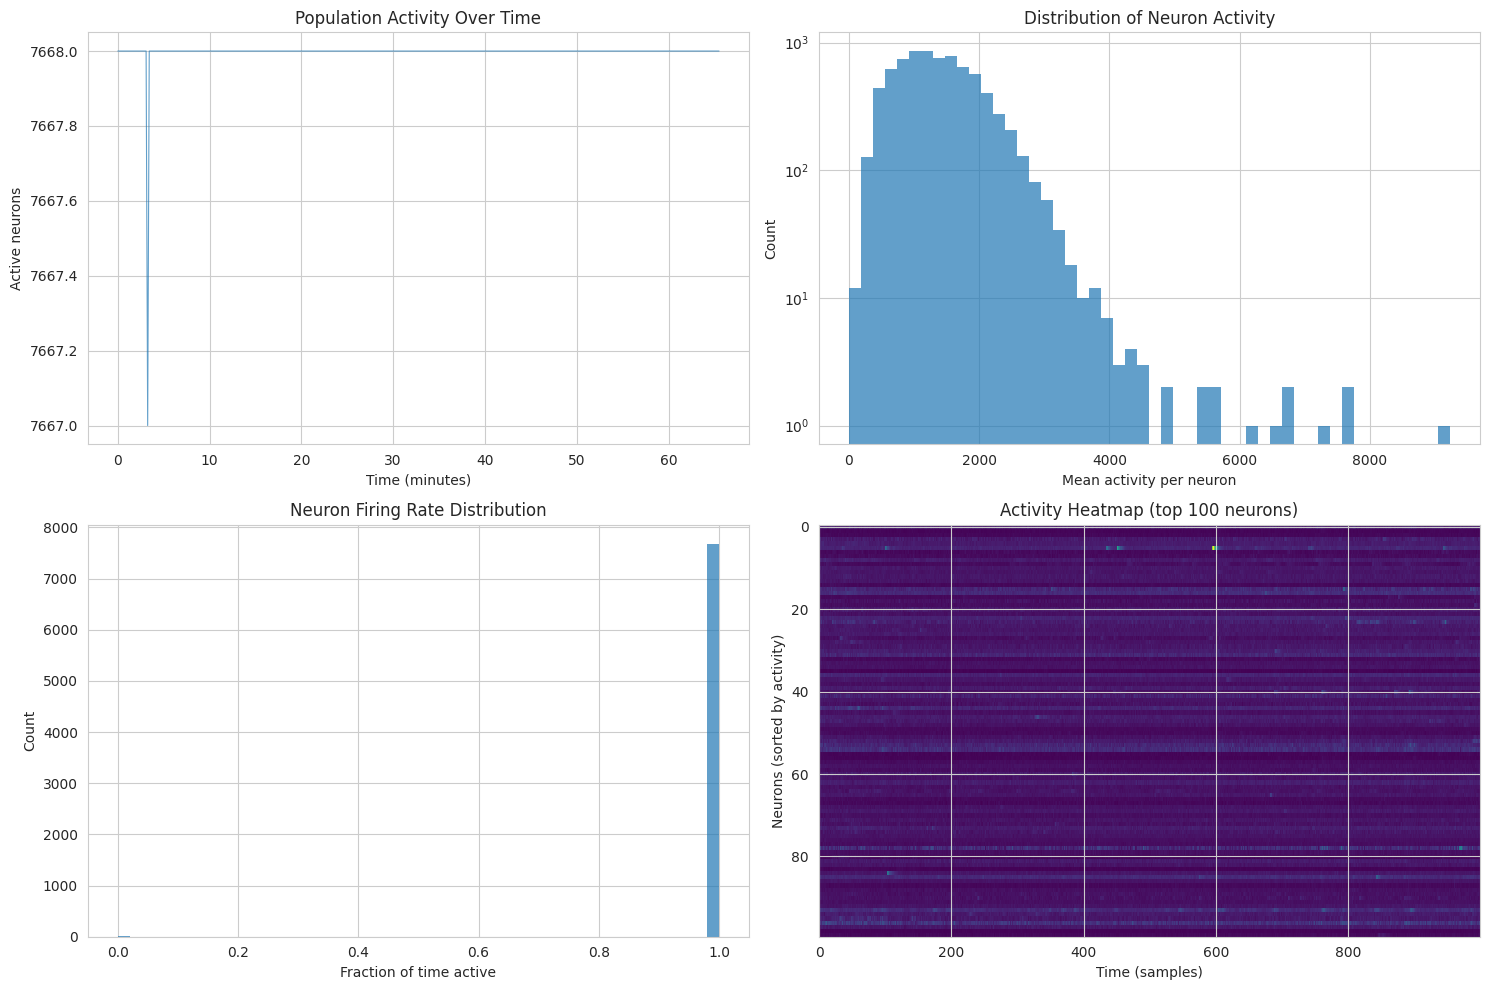

In [17]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Get activity matrix
# activity_matrix, timestamps = session.get_activity_matrix()
print(f"Activity matrix shape: {activity_matrix.shape}")
print(f"Session duration: {timestamps[-1]:.1f} seconds ({timestamps[-1]/60:.1f} minutes)")

# 1. DATA OVERVIEW & BASIC STATISTICS
print(f"\n=== DATA OVERVIEW ===")
print(f"Total neurons: {activity_matrix.shape[1]}")
print(f"Total timepoints: {activity_matrix.shape[0]}")
print(f"Sampling rate: {1/np.mean(np.diff(timestamps)):.1f} Hz")

# Basic activity statistics
total_events = np.sum(activity_matrix > 0.1)  # Using 0.1 as threshold for "active"
sparsity = 1 - (total_events / activity_matrix.size)
print(f"Sparsity: {sparsity:.3f} ({100*sparsity:.1f}% zeros)")

# Per-neuron statistics
neuron_firing_rates = np.mean(activity_matrix > 0.5, axis=0)  # Fraction of time active
neuron_mean_activity = np.mean(activity_matrix, axis=0)

print(f"Active neurons (>1% time): {np.sum(neuron_firing_rates > 0.01)}/{len(neuron_firing_rates)}")
print(f"Mean firing rate: {np.mean(neuron_firing_rates):.3f}")

# 2. POPULATION ACTIVITY OVER TIME
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Population sum over time (downsampled for visualization)
downsample_factor = 50  # Show every 50th timepoint
pop_activity = np.sum(activity_matrix > 0.1, axis=1)  # Number of active neurons per timepoint
time_ds = timestamps[::downsample_factor]
pop_ds = pop_activity[::downsample_factor]

axes[0,0].plot(time_ds/60, pop_ds, alpha=0.7, linewidth=0.8)
axes[0,0].set_xlabel('Time (minutes)')
axes[0,0].set_ylabel('Active neurons')
axes[0,0].set_title('Population Activity Over Time')

# Distribution of neuron activity levels
axes[0,1].hist(neuron_mean_activity, bins=50, alpha=0.7, edgecolor='none')
axes[0,1].set_xlabel('Mean activity per neuron')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Neuron Activity')
axes[0,1].set_yscale('log')

# Firing rate distribution
axes[1,0].hist(neuron_firing_rates, bins=50, alpha=0.7, edgecolor='none')
axes[1,0].set_xlabel('Fraction of time active')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Neuron Firing Rate Distribution')

# Activity heatmap (sample of neurons)
n_sample = min(100, activity_matrix.shape[1])  # Sample 100 neurons
sample_idx = np.random.choice(activity_matrix.shape[1], n_sample, replace=False)
sample_idx = sample_idx[np.argsort(neuron_firing_rates[sample_idx])[::-1]]  # Sort by activity

# Downsample time for heatmap
time_sample = slice(0, min(1000, activity_matrix.shape[0]))  # First 1000 timepoints
heatmap_data = activity_matrix[time_sample, sample_idx].T

im = axes[1,1].imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
axes[1,1].set_xlabel('Time (samples)')
axes[1,1].set_ylabel('Neurons (sorted by activity)')
axes[1,1].set_title(f'Activity Heatmap (top {n_sample} neurons)')

plt.tight_layout()
plt.show()

# # 3. FOV BREAKDOWN
# print(f"\n=== FOV BREAKDOWN ===")
# for fov_name, fov in session.fovs.items():
#     print(f"{fov_name}: {fov.n_neurons} neurons ({fov.n_neurons/session.n_total_neurons*100:.1f}%)")

<Axes: >

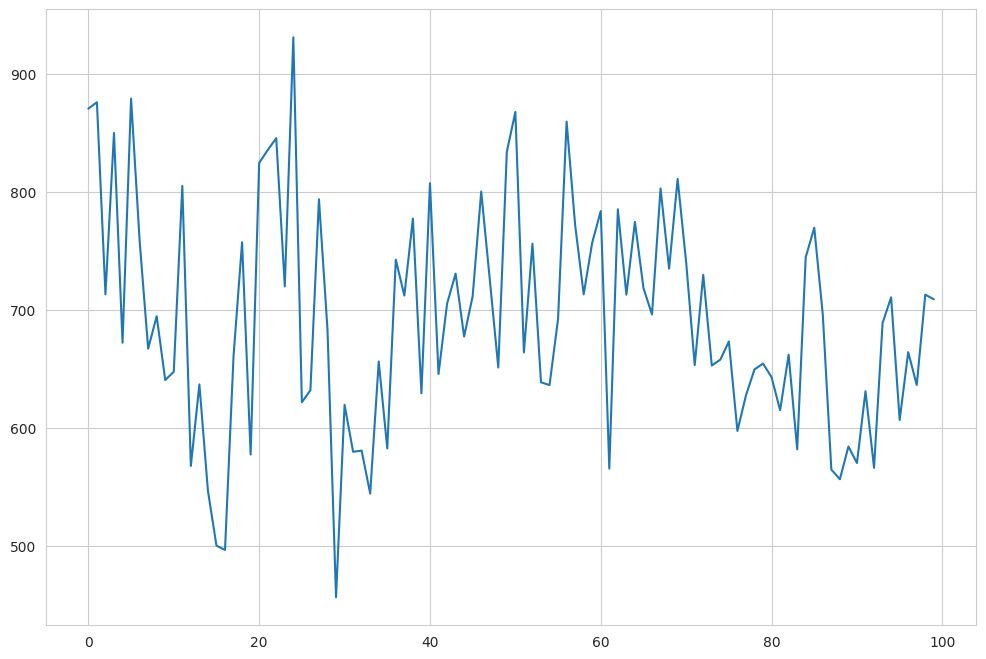

In [18]:
sns.lineplot(activity_matrix[:100,1000])

In [12]:
session.plot_binary_activity_heatmap(time_window=50, threshold=0.9)

AttributeError: 'tuple' object has no attribute 'plot_binary_activity_heatmap'

Working with (19081, 7673) data (time x neurons)

=== INFORMATION CONTENT ANALYSIS ===
Mean neuron entropy: 1.642

=== DIMENSIONALITY ANALYSIS ===
Components for 80% variance: 865/7673 (11.3%)
Components for 95% variance: 1497/7673 (19.5%)

=== TIMESCALE ANALYSIS ===


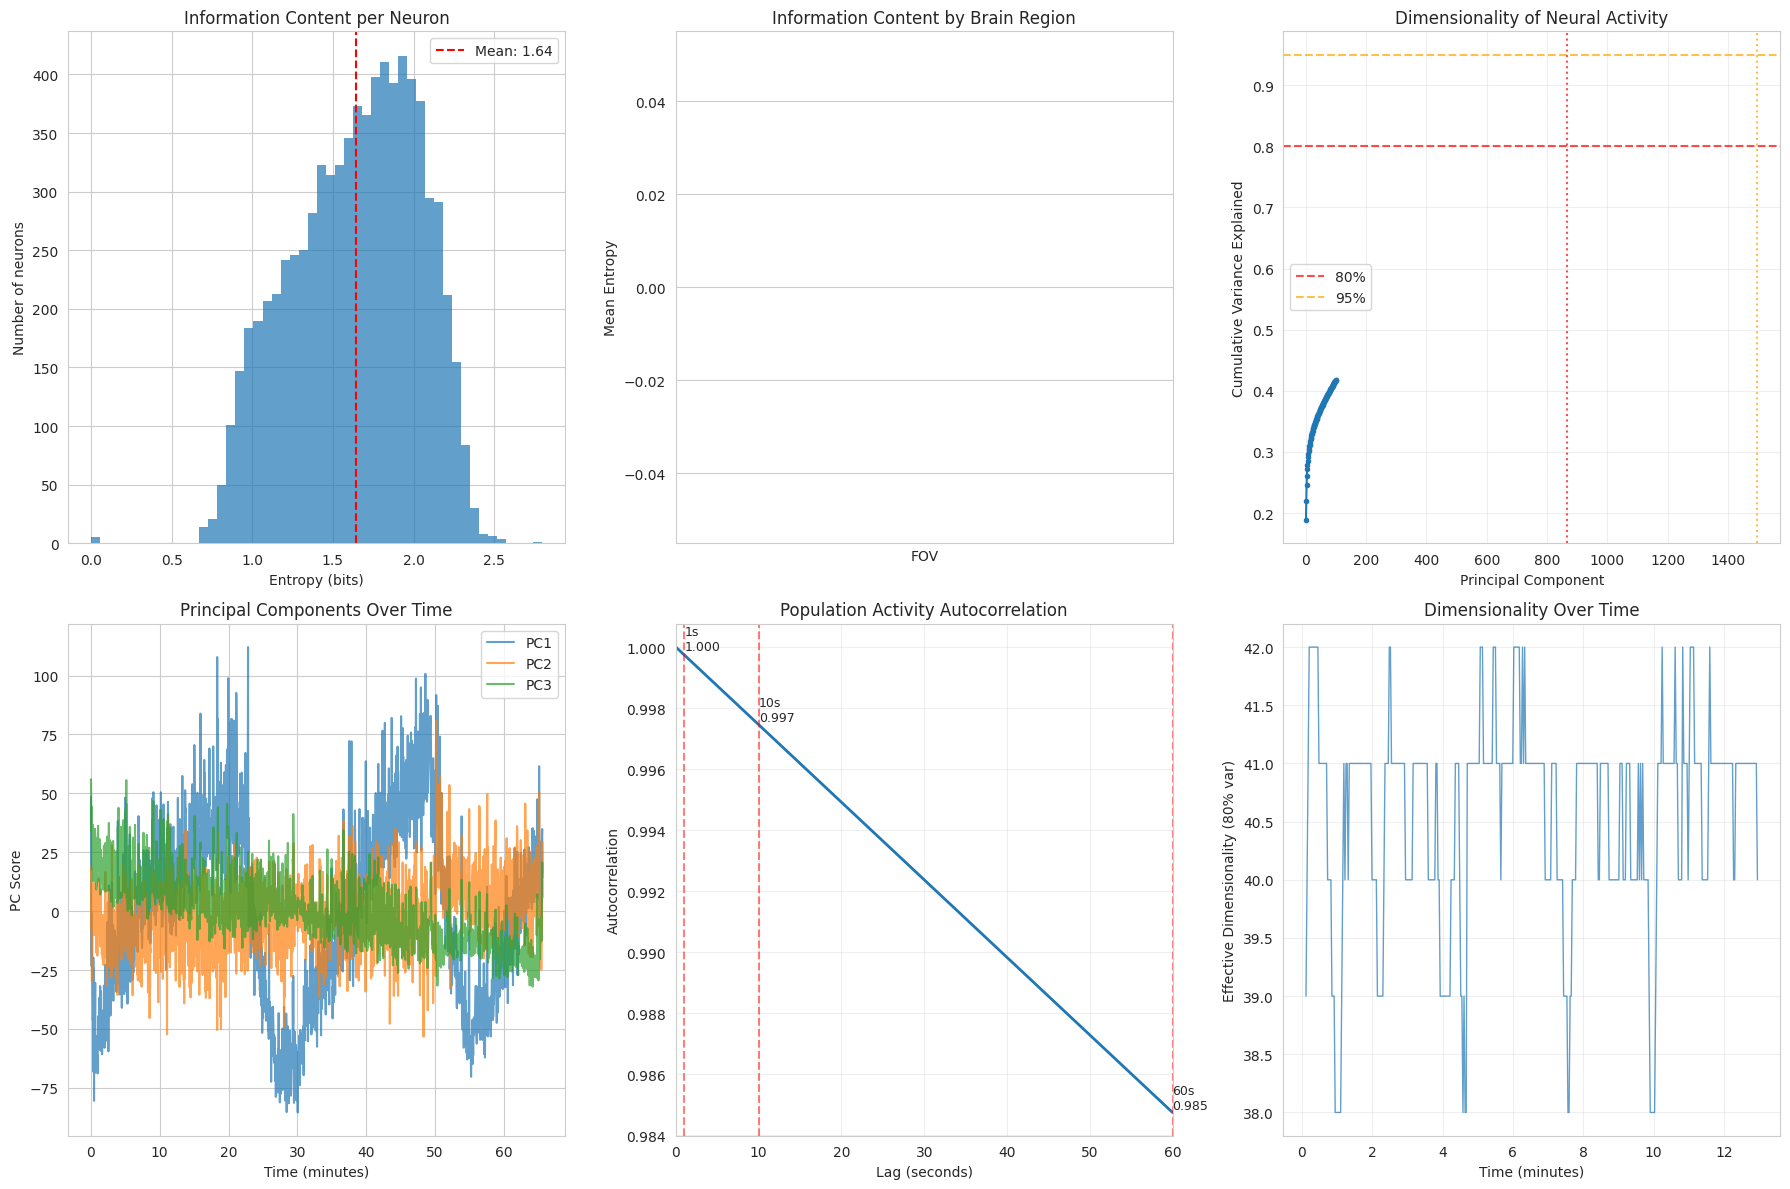


=== SUMMARY ===
Effective dimensionality: 865/7673 neurons (11.3%)
Autocorrelation at 1s: 1.000
Autocorrelation at 10s: 0.997
Autocorrelation at 1min: 0.985
Mean sliding dimensionality: 40.6 ± 0.9


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from scipy.signal import correlate
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# Assume activity_matrix, timestamps, and session are already loaded
print(f"Working with {activity_matrix.shape} data (time x neurons)")

# =============================================================================
# 1. INFORMATION CONTENT ANALYSIS
# =============================================================================
print("\n=== INFORMATION CONTENT ANALYSIS ===")

# Calculate entropy for each neuron (measure of information content)
def calculate_neuron_entropy(activity, bins=20):
    """Calculate entropy for each neuron's activity distribution"""
    entropies = []
    for i in range(activity.shape[1]):
        hist, _ = np.histogram(activity[:, i], bins=bins, density=True)
        hist = hist[hist > 0]  # Remove zero bins
        entropies.append(entropy(hist))
    return np.array(entropies)

neuron_entropies = calculate_neuron_entropy(activity_matrix)
print(f"Mean neuron entropy: {np.mean(neuron_entropies):.3f}")

# Information content per FOV
# fov_entropies = {}
# neuron_idx = 0
# for fov_name, fov in session.fovs.items():
#     fov_activity = activity_matrix[:, neuron_idx:neuron_idx+fov.n_neurons]
#     fov_entropies[fov_name] = np.mean(calculate_neuron_entropy(fov_activity))
    # neuron_idx += fov.n_neurons

# =============================================================================
# 2. DIMENSIONALITY ANALYSIS (PCA)
# =============================================================================
print("\n=== DIMENSIONALITY ANALYSIS ===")

# Standardize data for PCA (sample every 10th timepoint for efficiency)
sample_step = 10
activity_sample = activity_matrix[::sample_step, :]
scaler = StandardScaler()
activity_scaled = scaler.fit_transform(activity_sample)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(activity_scaled)
explained_var = pca.explained_variance_ratio_

# Find number of components for 80% and 95% variance
cumvar = np.cumsum(explained_var)
n_80 = np.argmax(cumvar >= 0.8) + 1
n_95 = np.argmax(cumvar >= 0.95) + 1

print(f"Components for 80% variance: {n_80}/{activity_matrix.shape[1]} ({n_80/activity_matrix.shape[1]*100:.1f}%)")
print(f"Components for 95% variance: {n_95}/{activity_matrix.shape[1]} ({n_95/activity_matrix.shape[1]*100:.1f}%)")

# =============================================================================
# 3. TIMESCALE ANALYSIS
# =============================================================================
print("\n=== TIMESCALE ANALYSIS ===")

# Calculate population activity for correlation analysis
pop_activity = np.mean(activity_matrix > 0.1, axis=1)  # Fraction of active neurons

# Calculate autocorrelation at different lags
def calculate_autocorr(signal, max_lag_samples):
    """Calculate autocorrelation up to max_lag"""
    autocorr = correlate(signal, signal, mode='full')
    mid = len(autocorr) // 2
    autocorr = autocorr[mid:mid+max_lag_samples+1]
    return autocorr / autocorr[0]  # Normalize

# Define time lags to analyze
sampling_rate = 1 / np.mean(np.diff(timestamps))
lags_seconds = [1, 10, 60]  # 1s, 10s, 1min
max_lag_samples = int(60 * sampling_rate)  # 1 minute worth of samples

autocorr = calculate_autocorr(pop_activity, max_lag_samples)
lag_times = np.arange(len(autocorr)) / sampling_rate

# =============================================================================
# PLOTTING
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Information content by neuron
axes[0,0].hist(neuron_entropies, bins=50, alpha=0.7, edgecolor='none')
axes[0,0].set_xlabel('Entropy (bits)')
axes[0,0].set_ylabel('Number of neurons')
axes[0,0].set_title('Information Content per Neuron')
axes[0,0].axvline(np.mean(neuron_entropies), color='red', linestyle='--', label=f'Mean: {np.mean(neuron_entropies):.2f}')
axes[0,0].legend()

# 2. Information content by FOV
fov_names = list(fov_entropies.keys())
fov_entropy_values = list(fov_entropies.values())
axes[0,1].bar(range(len(fov_names)), fov_entropy_values, alpha=0.7)
axes[0,1].set_xlabel('FOV')
axes[0,1].set_ylabel('Mean Entropy')
axes[0,1].set_title('Information Content by Brain Region')
axes[0,1].set_xticks(range(len(fov_names)))
axes[0,1].set_xticklabels(fov_names, rotation=45)

# 3. PCA explained variance
axes[0,2].plot(np.arange(1, min(100, len(explained_var))+1), 
               cumvar[:min(100, len(explained_var))], 'o-', markersize=3)
axes[0,2].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80%')
axes[0,2].axhline(0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
axes[0,2].axvline(n_80, color='red', linestyle=':', alpha=0.7)
axes[0,2].axvline(n_95, color='orange', linestyle=':', alpha=0.7)
axes[0,2].set_xlabel('Principal Component')
axes[0,2].set_ylabel('Cumulative Variance Explained')
axes[0,2].set_title('Dimensionality of Neural Activity')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. First few PCs over time
time_sample = timestamps[::sample_step]
for i in range(3):
    axes[1,0].plot(time_sample/60, pca_result[:, i], alpha=0.7, label=f'PC{i+1}')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('PC Score')
axes[1,0].set_title('Principal Components Over Time')
axes[1,0].legend()

# 5. Autocorrelation function
axes[1,1].plot(lag_times, autocorr, linewidth=2)
axes[1,1].set_xlabel('Lag (seconds)')
axes[1,1].set_ylabel('Autocorrelation')
axes[1,1].set_title('Population Activity Autocorrelation')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(0, 60)

# Add vertical lines for key timescales
for lag in lags_seconds:
    if lag <= 60:
        lag_idx = int(lag * sampling_rate)
        if lag_idx < len(autocorr):
            axes[1,1].axvline(lag, color='red', linestyle='--', alpha=0.5)
            axes[1,1].text(lag, autocorr[lag_idx], f'{lag}s\n{autocorr[lag_idx]:.3f}', 
                          verticalalignment='bottom', fontsize=9)

# 6. Effective dimensionality over time windows
window_size = int(60 * sampling_rate)  # 1-minute windows
step_size = int(10 * sampling_rate)    # 10-second steps

def sliding_dimensionality(data, window_size, step_size, var_threshold=0.8):
    """Calculate effective dimensionality in sliding windows"""
    dims = []
    times = []
    
    for start in range(0, data.shape[0] - window_size, step_size):
        window = data[start:start+window_size, :]
        window_scaled = StandardScaler().fit_transform(window)
        
        pca_window = PCA()
        pca_window.fit(window_scaled)
        cumvar_window = np.cumsum(pca_window.explained_variance_ratio_)
        
        dim = np.argmax(cumvar_window >= var_threshold) + 1
        dims.append(dim)
        times.append(timestamps[start + window_size//2])
    
    return np.array(times), np.array(dims)

# Calculate sliding dimensionality (subsample for efficiency)
subsample_factor = 5
data_sub = activity_matrix[::subsample_factor, :]
times_sub = timestamps[::subsample_factor]

window_times, sliding_dims = sliding_dimensionality(
    data_sub, 
    window_size // subsample_factor, 
    step_size // subsample_factor
)

axes[1,2].plot(window_times/60, sliding_dims, alpha=0.7, linewidth=1)
axes[1,2].set_xlabel('Time (minutes)')
axes[1,2].set_ylabel('Effective Dimensionality (80% var)')
axes[1,2].set_title('Dimensionality Over Time')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print(f"\n=== SUMMARY ===")
# print(f"Most informative FOV: {max(fov_entropies, key=fov_entropies.get)} (entropy: {max(fov_entropies.values()):.3f})")
# print(f"Least informative FOV: {min(fov_entropies, key=fov_entropies.get)} (entropy: {min(fov_entropies.values()):.3f})")
print(f"Effective dimensionality: {n_80}/{activity_matrix.shape[1]} neurons ({n_80/activity_matrix.shape[1]*100:.1f}%)")
print(f"Autocorrelation at 1s: {autocorr[int(1*sampling_rate)]:.3f}")
print(f"Autocorrelation at 10s: {autocorr[int(10*sampling_rate)]:.3f}")
if len(autocorr) > int(60*sampling_rate):
    print(f"Autocorrelation at 1min: {autocorr[int(60*sampling_rate)]:.3f}")
print(f"Mean sliding dimensionality: {np.mean(sliding_dims):.1f} ± {np.std(sliding_dims):.1f}")

In [22]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("=== DETAILED SUMMARY STATISTICS ===")

# =============================================================================
# 1. ACTIVITY VALUE RANGES
# =============================================================================
print("\n--- Activity Value Ranges ---")
print(f"Global min: {np.min(activity_matrix):.4f}")
print(f"Global max: {np.max(activity_matrix):.4f}")
print(f"Global mean: {np.mean(activity_matrix):.4f}")
print(f"Global median: {np.median(activity_matrix):.4f}")
print(f"Global std: {np.std(activity_matrix):.4f}")


=== DETAILED SUMMARY STATISTICS ===

--- Activity Value Ranges ---
Global min: -532.0000
Global max: 28183.3633
Global mean: 1413.2856
Global median: 1296.1783
Global std: 832.9439


=== DETAILED SUMMARY STATISTICS ===

--- Activity Value Ranges ---
Global min: 0.0000
Global max: 18622.3379
Global mean: 16.0608
Global median: 0.0000
Global std: 114.6837

Percentiles:
  1th: 0.0000
  5th: 0.0000
  10th: 0.0000
  25th: 0.0000
  50th: 0.0000
  75th: 0.0000
  90th: 24.7393
  95th: 74.6570
  99th: 287.1509

Fraction of exact zeros: 0.854 (85.4%)

Fraction above thresholds:
  >0.01: 0.1464 (14.64%)
  >0.1: 0.1462 (14.62%)
  >0.5: 0.1453 (14.53%)
  >1.0: 0.1442 (14.42%)
  >2.0: 0.1420 (14.20%)

--- Neuron-Level Statistics ---
Most active neuron (mean): 503.9446
Least active neuron (mean): 0.6359
Most active neuron (max): 18622.3379
Most active neuron (% time active): 45.0%
Completely silent neurons: 0/11771 (0.0%)
Very active neurons (>10% time): 11769/11771 (100.0%)

--- Top 100 Most Active Neurons by FOV ---
Top 100 neurons by FOV:
  FOV_00: 26/100 (26% of top 100, 1.3% of FOV_00)
  FOV_02: 24/100 (24% of top 100, 1.7% of FOV_02)
  FOV_04: 22/100 (22% of top 100, 1.4% o

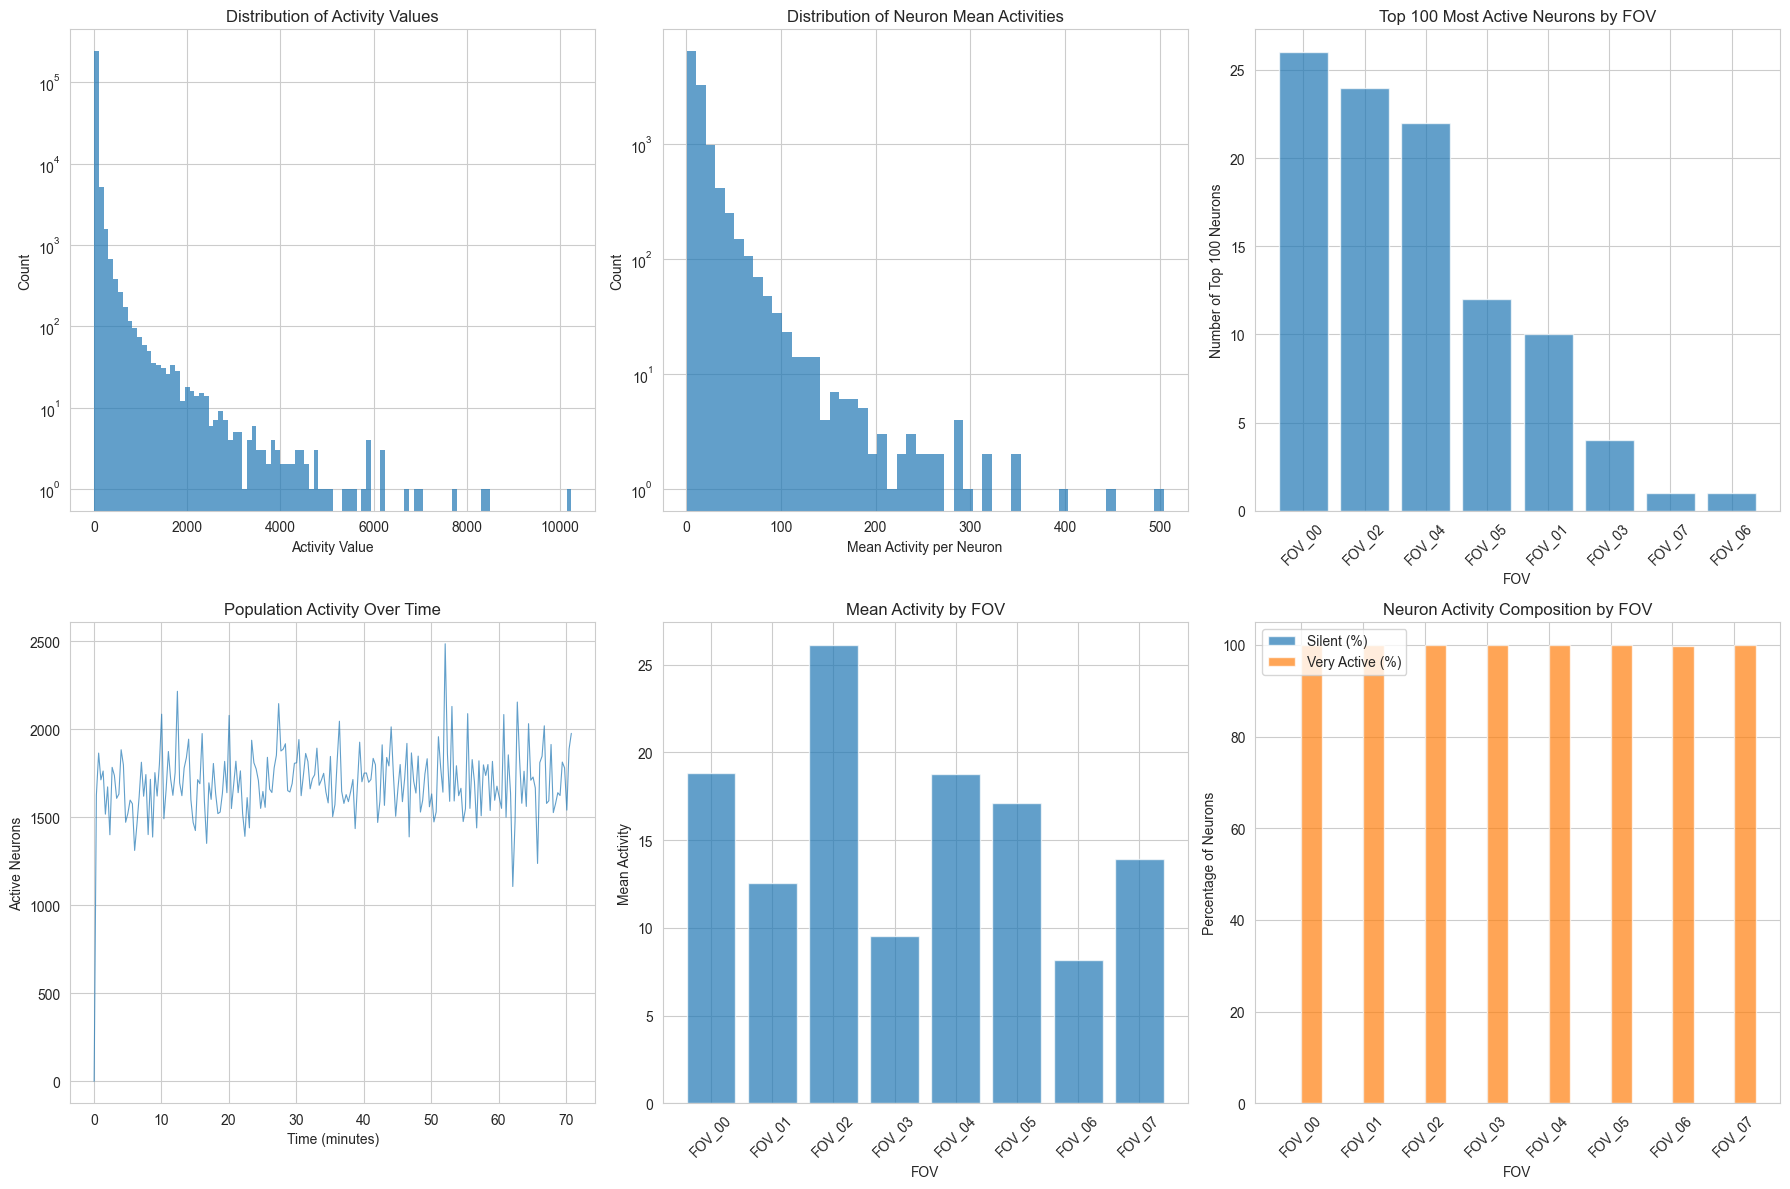


=== FINAL SUMMARY ===
Dataset: 21157 timepoints × 11771 neurons
Duration: 71.0 minutes
Most active FOV: FOV_02 (mean activity: 26.1335)
Most represented in top 100: FOV_00 (26 neurons)
Sparsity: 85.4% exact zeros, 85.4% below threshold
Dynamic range: 169.8x above mean non-zero


In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("=== DETAILED SUMMARY STATISTICS ===")

# =============================================================================
# 1. ACTIVITY VALUE RANGES
# =============================================================================
print("\n--- Activity Value Ranges ---")
print(f"Global min: {np.min(activity_matrix):.4f}")
print(f"Global max: {np.max(activity_matrix):.4f}")
print(f"Global mean: {np.mean(activity_matrix):.4f}")
print(f"Global median: {np.median(activity_matrix):.4f}")
print(f"Global std: {np.std(activity_matrix):.4f}")

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
perc_values = np.percentile(activity_matrix, percentiles)
print(f"\nPercentiles:")
for p, v in zip(percentiles, perc_values):
    print(f"  {p}th: {v:.4f}")

# Fraction of zeros
zero_fraction = np.mean(activity_matrix == 0)
print(f"\nFraction of exact zeros: {zero_fraction:.3f} ({zero_fraction*100:.1f}%)")

# Fraction above different thresholds
thresholds = [0.01, 0.1, 0.5, 1.0, 2.0]
print(f"\nFraction above thresholds:")
for thresh in thresholds:
    frac = np.mean(activity_matrix > thresh)
    print(f"  >{thresh}: {frac:.4f} ({frac*100:.2f}%)")

# =============================================================================
# 2. NEURON-LEVEL STATISTICS
# =============================================================================
print("\n--- Neuron-Level Statistics ---")

# Calculate per-neuron statistics
neuron_means = np.mean(activity_matrix, axis=0)
neuron_maxes = np.max(activity_matrix, axis=0)
neuron_stds = np.std(activity_matrix, axis=0)
neuron_active_fraction = np.mean(activity_matrix > 0.1, axis=0)  # Fraction of time active

print(f"Most active neuron (mean): {np.max(neuron_means):.4f}")
print(f"Least active neuron (mean): {np.min(neuron_means):.4f}")
print(f"Most active neuron (max): {np.max(neuron_maxes):.4f}")
print(f"Most active neuron (% time active): {np.max(neuron_active_fraction)*100:.1f}%")

# Silent neurons
silent_neurons = np.sum(neuron_maxes == 0)
print(f"Completely silent neurons: {silent_neurons}/{len(neuron_means)} ({silent_neurons/len(neuron_means)*100:.1f}%)")

# Very active neurons
very_active = np.sum(neuron_active_fraction > 0.1)  # Active >10% of time
print(f"Very active neurons (>10% time): {very_active}/{len(neuron_means)} ({very_active/len(neuron_means)*100:.1f}%)")

# =============================================================================
# 3. TOP 100 MOST ACTIVE NEURONS BY FOV
# =============================================================================
print("\n--- Top 100 Most Active Neurons by FOV ---")

# Get indices of top 100 most active neurons (by mean activity)
top_100_indices = np.argsort(neuron_means)[-100:][::-1]  # Top 100, sorted descending

# Map neuron indices to FOVs
def get_neuron_fov_mapping(session):
    """Create mapping from neuron index to FOV name"""
    neuron_to_fov = {}
    neuron_idx = 0
    
    for fov_name, fov in session.fovs.items():
        for i in range(fov.n_neurons):
            neuron_to_fov[neuron_idx] = fov_name
            neuron_idx += 1
    
    return neuron_to_fov

neuron_to_fov = get_neuron_fov_mapping(session)

# Count top neurons by FOV
top_100_fovs = [neuron_to_fov[idx] for idx in top_100_indices]
fov_counts = pd.Series(top_100_fovs).value_counts()

print("Top 100 neurons by FOV:")
for fov, count in fov_counts.items():
    total_in_fov = session.fovs[fov].n_neurons
    percentage = count/total_in_fov*100
    print(f"  {fov}: {count}/100 ({count}% of top 100, {percentage:.1f}% of {fov})")

# =============================================================================
# 4. TEMPORAL STATISTICS
# =============================================================================
print("\n--- Temporal Statistics ---")

# Population activity over time
pop_activity = np.sum(activity_matrix > 0.1, axis=1)  # Number of active neurons per timepoint
pop_mean_activity = np.mean(activity_matrix, axis=1)  # Mean activity per timepoint

print(f"Max simultaneous active neurons: {np.max(pop_activity)}/{activity_matrix.shape[1]} ({np.max(pop_activity)/activity_matrix.shape[1]*100:.1f}%)")
print(f"Min simultaneous active neurons: {np.min(pop_activity)}")
print(f"Mean simultaneous active neurons: {np.mean(pop_activity):.1f}")

# Most/least active time periods
most_active_time = timestamps[np.argmax(pop_activity)]
least_active_time = timestamps[np.argmin(pop_activity)]
print(f"Most active timepoint: {most_active_time:.1f}s ({most_active_time/60:.1f}min)")
print(f"Least active timepoint: {least_active_time:.1f}s ({least_active_time/60:.1f}min)")

# =============================================================================
# 5. FOV-LEVEL COMPARISONS
# =============================================================================
print("\n--- FOV-Level Comparisons ---")

fov_stats = {}
neuron_idx = 0

for fov_name, fov in session.fovs.items():
    fov_activity = activity_matrix[:, neuron_idx:neuron_idx+fov.n_neurons]
    
    fov_stats[fov_name] = {
        'n_neurons': fov.n_neurons,
        'mean_activity': np.mean(fov_activity),
        'max_activity': np.max(fov_activity),
        'active_fraction': np.mean(fov_activity > 0.1),
        'silent_neurons': np.sum(np.max(fov_activity, axis=0) == 0),
        'very_active_neurons': np.sum(np.mean(fov_activity > 0.1, axis=0) > 0.1)
    }
    
    neuron_idx += fov.n_neurons

# Create DataFrame for easier viewing
fov_df = pd.DataFrame(fov_stats).T
fov_df['silent_pct'] = fov_df['silent_neurons'] / fov_df['n_neurons'] * 100
fov_df['very_active_pct'] = fov_df['very_active_neurons'] / fov_df['n_neurons'] * 100

print("FOV Statistics:")
print(fov_df.round(4))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Activity value distribution (log scale)
axes[0,0].hist(activity_matrix.flatten()[::1000], bins=100, alpha=0.7, edgecolor='none')  # Sample for speed
axes[0,0].set_xlabel('Activity Value')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Distribution of Activity Values')
axes[0,0].set_yscale('log')

# 2. Neuron activity distribution
axes[0,1].hist(neuron_means, bins=50, alpha=0.7, edgecolor='none')
axes[0,1].set_xlabel('Mean Activity per Neuron')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Neuron Mean Activities')
axes[0,1].set_yscale('log')

# 3. Top 100 neurons by FOV
axes[0,2].bar(range(len(fov_counts)), fov_counts.values, alpha=0.7)
axes[0,2].set_xlabel('FOV')
axes[0,2].set_ylabel('Number of Top 100 Neurons')
axes[0,2].set_title('Top 100 Most Active Neurons by FOV')
axes[0,2].set_xticks(range(len(fov_counts)))
axes[0,2].set_xticklabels(fov_counts.index, rotation=45)

# 4. Population activity over time (downsampled)
downsample = 100
axes[1,0].plot(timestamps[::downsample]/60, pop_activity[::downsample], alpha=0.7, linewidth=0.8)
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('Active Neurons')
axes[1,0].set_title('Population Activity Over Time')

# 5. FOV activity comparison
axes[1,1].bar(range(len(fov_df)), fov_df['mean_activity'], alpha=0.7)
axes[1,1].set_xlabel('FOV')
axes[1,1].set_ylabel('Mean Activity')
axes[1,1].set_title('Mean Activity by FOV')
axes[1,1].set_xticks(range(len(fov_df)))
axes[1,1].set_xticklabels(fov_df.index, rotation=45)

# 6. FOV neuron composition
width = 0.35
x = np.arange(len(fov_df))
axes[1,2].bar(x - width/2, fov_df['silent_pct'], width, label='Silent (%)', alpha=0.7)
axes[1,2].bar(x + width/2, fov_df['very_active_pct'], width, label='Very Active (%)', alpha=0.7)
axes[1,2].set_xlabel('FOV')
axes[1,2].set_ylabel('Percentage of Neurons')
axes[1,2].set_title('Neuron Activity Composition by FOV')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(fov_df.index, rotation=45)
axes[1,2].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. FINAL SUMMARY
# =============================================================================
print(f"\n=== FINAL SUMMARY ===")
print(f"Dataset: {activity_matrix.shape[0]} timepoints × {activity_matrix.shape[1]} neurons")
print(f"Duration: {timestamps[-1]/60:.1f} minutes")
print(f"Most active FOV: {fov_df['mean_activity'].idxmax()} (mean activity: {fov_df['mean_activity'].max():.4f})")
print(f"Most represented in top 100: {fov_counts.index[0]} ({fov_counts.iloc[0]} neurons)")
print(f"Sparsity: {zero_fraction*100:.1f}% exact zeros, {(1-np.mean(activity_matrix > 0.1))*100:.1f}% below threshold")
print(f"Dynamic range: {np.max(activity_matrix)/np.mean(activity_matrix[activity_matrix > 0]):.1f}x above mean non-zero")

## Treescope

In [13]:
import treescope
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [15]:
activity_matrix.T

array([[ 5829.508 ,  5416.21  ,  5522.308 , ...,  7551.001 ,  6068.1104,
         5160.6245],
       [  813.8649,   747.2885,   719.0122, ...,   928.3858,   946.6298,
          966.383 ],
       [24296.914 , 23340.479 , 22618.082 , ...,  8590.089 , 18666.008 ,
        20779.568 ],
       ...,
       [ 2168.3235,  1959.9626,  1806.8248, ...,  2022.7043,  2028.1979,
         1880.6025],
       [ 1109.098 ,  1009.5708,  1038.912 , ...,  1040.6742,  1144.9987,
         1109.9138],
       [  850.5574,   865.0278,   931.1831, ...,   936.6764,   919.4776,
          661.7093]], dtype=float32)

In [28]:
activity_matrix[500:550, 5000:5010].T

array([[1452.576  , 1537.3154 , 1477.0444 , 1406.6608 , 1452.1794 ,
        1316.2368 , 1271.1023 , 1705.5176 , 1225.064  , 1477.3329 ,
        1558.0637 , 1534.6538 , 1522.7389 , 1570.82   , 1413.4098 ,
        1276.4531 , 1577.7408 , 1562.1715 , 1663.0897 , 1520.8124 ,
        1477.8368 , 1527.0488 , 1632.003  , 1414.639  , 1460.0378 ,
        1411.7196 , 1501.0492 , 1356.6735 , 1195.2572 , 1169.9071 ,
        1540.5735 , 1321.9044 , 1394.1122 , 1103.9504 , 1375.0797 ,
        1554.5975 , 1445.863  , 1307.3586 , 1769.7168 , 1404.1451 ,
        1620.1294 , 1151.666  , 1703.3457 , 1354.0093 , 1411.7943 ,
        1845.4858 , 1706.8656 , 1582.0227 , 1456.7842 , 1651.5427 ],
       [1046.3005 , 1442.8625 , 1465.679  , 1568.1633 , 1597.2043 ,
        1557.552  , 1325.1782 , 1613.6099 , 1195.4886 , 1633.0488 ,
        1237.217  , 1312.6361 , 1388.1344 , 1390.9966 , 1426.9578 ,
        1303.7322 , 1457.5958 , 1115.3796 , 1349.6418 , 1436.0941 ,
        1335.5747 , 1377.5529 , 1401.8097 , 1485.9873 , 1244.8026 ,
        1258.5908 , 1363.6082 , 1022.1139 , 1755.9259 , 1220.0923 ,
        1178.4515 , 1096.0836 , 1524.9313 , 1495.7673 ,  983.19037,
        1094.9242 , 1096.5575 , 1420.5991 , 1343.3473 , 1320.237  ,
        1133.7511 , 1375.5333 , 1390.4652 , 1415.7705 , 1228.8287 ,
        1417.9498 , 1179.8368 , 1409.1405 , 1197.8488 , 1109.1229 ],
       [ 776.88995,  813.26337,  867.5953 ,  935.4931 ,  919.47455,
         969.8019 ,  824.62305, 1053.3394 , 1053.1273 ,  853.8799 ,
         906.71643,  930.50934, 1003.5092 ,  883.4603 ,  960.9279 ,
         961.30365, 1029.9025 ,  945.8137 , 1064.6139 , 1228.7144 ,
         850.5436 ,  983.16846,  863.6063 ,  882.7139 ,  902.1957 ,
         979.92017,  951.49866,  874.63226, 1063.3105 ,  915.6473 ,
        1029.7373 ,  954.61554,  709.0095 ,  831.05896, 1014.00543,
        1049.9329 ,  878.49005,  901.4932 ,  835.84344,  798.1547 ,
         968.68463,  761.9443 ,  839.2804 , 1105.7744 , 1077.1808 ,
         996.62067,  849.6134 ,  951.6038 ,  958.91895,  995.751  ],
       [1567.6865 , 1696.6766 , 1665.587  , 1968.5503 , 1844.3704 ,
        1810.4374 , 1744.2477 , 1544.8289 , 1603.322  , 1956.4088 ,
        1483.2153 , 1546.7651 , 1440.6453 , 1651.9789 , 1532.68   ,
        1444.3555 , 1624.4851 , 2023.8502 , 1729.1387 , 1648.8635 ,
        1841.3475 , 1776.0587 , 1749.9941 , 1868.3126 , 1796.446  ,
        1750.5326 , 1820.8295 , 1533.8152 , 1826.5732 , 1503.1294 ,
        1629.8536 , 1462.0294 , 1527.2214 , 1428.4915 , 1714.6339 ,
        1701.4935 , 1444.3994 , 1692.9458 , 1917.1552 , 1757.8059 ,
        1665.2704 , 1716.8872 , 1192.7479 , 1718.2937 , 1221.912  ,
        1678.4303 , 1776.1876 , 1770.8856 , 1487.5481 , 1660.9075 ],
       [1709.4359 , 1773.5597 , 1777.2113 , 1930.8146 , 1606.4906 ,
        2602.7004 , 1262.5856 , 2756.8325 , 2476.2524 , 3333.9148 ,
        2066.3044 , 1912.6874 , 2707.3193 , 3199.6929 , 3324.909  ,
        2010.4248 , 1583.4053 , 2862.2754 , 2049.8267 , 2062.2065 ,
        1654.9656 , 1948.2213 , 2029.7231 , 1584.5035 , 2600.5542 ,
        2119.1904 , 2838.2305 , 2117.3403 , 1720.4948 , 2167.0024 ,
        1760.6608 , 2202.6516 , 1542.7012 , 1496.1072 , 2220.4248 ,
        2729.8252 , 1936.7941 , 1808.3418 , 1778.497  , 1886.2212 ,
        2632.5828 , 1836.2489 , 2093.8865 , 1853.3276 , 2345.2742 ,
        2065.094  , 2050.5674 , 2725.9492 , 1647.2294 , 1824.941  ],
       [1411.9432 , 1489.9774 , 1362.4241 , 1321.0486 , 1411.0894 ,
        1140.4352 , 1182.9308 , 1186.5103 , 1369.5016 , 1239.5255 ,
        1412.2745 , 1172.4745 , 1205.5488 , 1239.6516 , 1161.29   ,
        1721.9077 , 1531.299  , 1561.837  , 1404.5316 , 1358.302  ,
        1724.1543 , 1552.1467 , 1221.2238 , 1643.1377 , 1380.6019 ,
        1279.2505 , 1457.2491 , 1181.3546 , 1188.7415 , 1351.6171 ,
        1099.9298 , 1141.2579 , 1272.3667 , 1257.6736 , 1333.8398 ,
        1306.8762 , 1359.6691 , 1330.0044 , 1142.9667 , 1397.0035 ,
        1412.5469 , 1409.1302 , 1596.3    , 1340.69

In [20]:
parent_dir = os.path.dirname(os.getcwd())
os.listdir(parent_dir)
pre_dir = os.path.join(parent_dir, '2_PREPROCESSING')
if pre_dir not in sys.path:
    sys.path.append(pre_dir)
    
from activity_preprocessor import CalciumDataPreprocessor

# from utils.load_meso_session import MesoscopeSession

## Neuroglancer

In [ ]:
# preprocessor = CalciumDataPreprocessor(neucoeff=0.7, temporal_smoothing=True)
# results = preprocessor.preprocess_session(session, 'processed_data/session_000.h5')

CALCIUM IMAGING PREPROCESSING PIPELINE

1. Loading ΔF/F data...
   Raw ΔF/F shape: (19081, 7673)
   Raw ΔF/F range: -2277.8 to 11374.2

2. Filtering neurons...
   Kept 6903 neurons out of 7673
   Filtered data range: -374.2 to 2721.4

3. Applying robust normalization...
   Normalized range: 0.000 to 1.000
   Normalized mean: 0.323, std: 0.186

4. Applying temporal smoothing...

5. Quality assessment...

6. Saving processed data to processed_data\session_000.h5
   Saved (19081, 6903) processed data matrix
   File size: 439.63 MB


In [14]:
import h5py

def load_processed_calcium_data(file_path):
    """
    Load processed calcium imaging data from HDF5 file
    
    Args:
        file_path: Path to the HDF5 file
        
    Returns:
        dict: Contains 'processed_data', 'timestamps', 'neuron_mask'
    """
    with h5py.File(file_path, 'r') as f:
        return {
            'processed_data': f['processed_data'][:],
            'timestamps': f['timestamps'][:],
            'neuron_mask': f['neuron_mask'][:]
        }
results = load_processed_calcium_data("processed_data/session_000.h5")

In [15]:
results['processed_data'].shape

(19081, 6903)

In [ ]:
import neuroglancer as ng

dimensions = ng.CoordinateSpace(
   names=['time', 'neurons',],
   units='',
   scales=[1, 1, 1],
)
viewer = ng.Viewer()

with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['raw'] = ng.ImageLayer(
      source=ng.LocalVolume(results['processed_data'], dimensions))
  s.layout = 'xy'
viewer

# USE THIS SHADER

# #uicontrol int channel slider(min=0, max=4)
# #uicontrol vec3 color color(default="red")
# #uicontrol float brightness slider(min=-1, max=1)
# #uicontrol float contrast slider(min=-3, max=3, step=0.01)
# void main() {
#   emitRGB(color *
#           (toNormalized(getDataValue(channel)) + brightness) *
#           exp(contrast));
# }

http://127.0.0.1:58769/v/6aed30e7a6fd6c6a0b6309b0405723712b2b82f7/

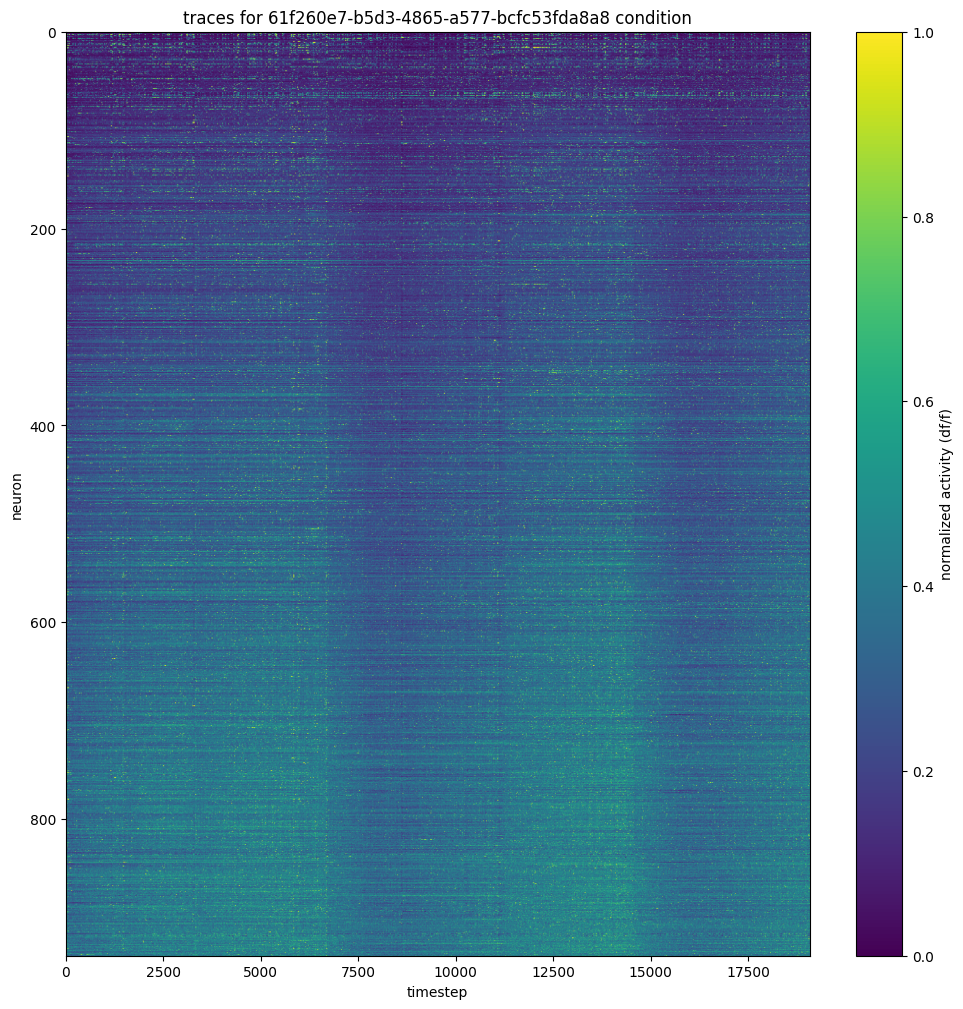

In [37]:
fig = plt.figure(figsize=(12, 12))
plt.title(f'traces for {session.eid} condition')
im = plt.imshow(results['processed_data'].T[:940,:], aspect="auto")
plt.xlabel('timestep')
plt.ylabel('neuron')
cbar = fig.colorbar(im)
cbar.set_label("normalized activity (df/f)")
plt.show();

## Rastermap

In [72]:
results['processed_data'].shape

(19081, 6903)

In [16]:
from rastermap import Rastermap

model = Rastermap(n_clusters=100, # number of clusters to compute
                  n_PCs=200, # number of PCs
                  locality=0.5, # locality in sorting is low here to get more global sorting (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                  ).fit(results['processed_data'].T)

2025-08-03 16:18:17,381 [INFO] normalizing data across axis=1
2025-08-03 16:18:18,415 [INFO] projecting out mean along axis=0
2025-08-03 16:18:18,956 [INFO] data normalized, 1.57sec
2025-08-03 16:18:18,957 [INFO] sorting activity: 6903 valid samples by 19081 timepoints
2025-08-03 16:18:21,107 [INFO] n_PCs = 200 computed, 3.73sec
2025-08-03 16:18:21,887 [INFO] 93 clusters computed, time 4.51sec
2025-08-03 16:18:27,996 [INFO] clusters sorted, time 10.61sec
2025-08-03 16:18:28,096 [INFO] clusters upsampled, time 10.71sec
2025-08-03 16:18:28,314 [INFO] rastermap complete, time 10.93sec


## TODO: PLOT TRIALS DATA ON TOP OF THIS

In [5]:
session.stimOn_times

array([  28.883,   39.116,   41.949,   49.616,   53.982,   64.199,
         66.799,   70.2  ,   73.982,   77.566,   81.1  ,   86.833,
         93.399,   97.616,  107.049,  113.166,  115.533,  118.332,
        121.882,  127.016,  133.482,  136.565,  143.432,  149.599,
        153.249,  158.867,  163.8  ,  171.749,  174.666,  186.882,
        196.115,  201.549,  204.25 ,  210.232,  215.166,      nan,
        223.1  ,  226.332,  234.665,  244.349,  249.282,  266.332,
        279.716,  284.332,  286.949,  291.315,  303.782,  310.599,
        319.915,  325.682,  331.732,  335.532,  342.249,  354.115,
        387.965,  399.399,  418.848,  434.898,  456.332,  460.498,
        463.015,  465.798,  482.348,  486.748,  490.231,  501.715,
        519.898,  522.415,  530.331,  533.081,  535.532,  537.948,
        542.932,  546.114,  550.764,  566.015,  574.131,  594.881,
        598.614,  610.081,  619.231,  636.564,  641.364,  651.398,
        659.148,  668.848,  676.631,  693.348,  709.414,  719.

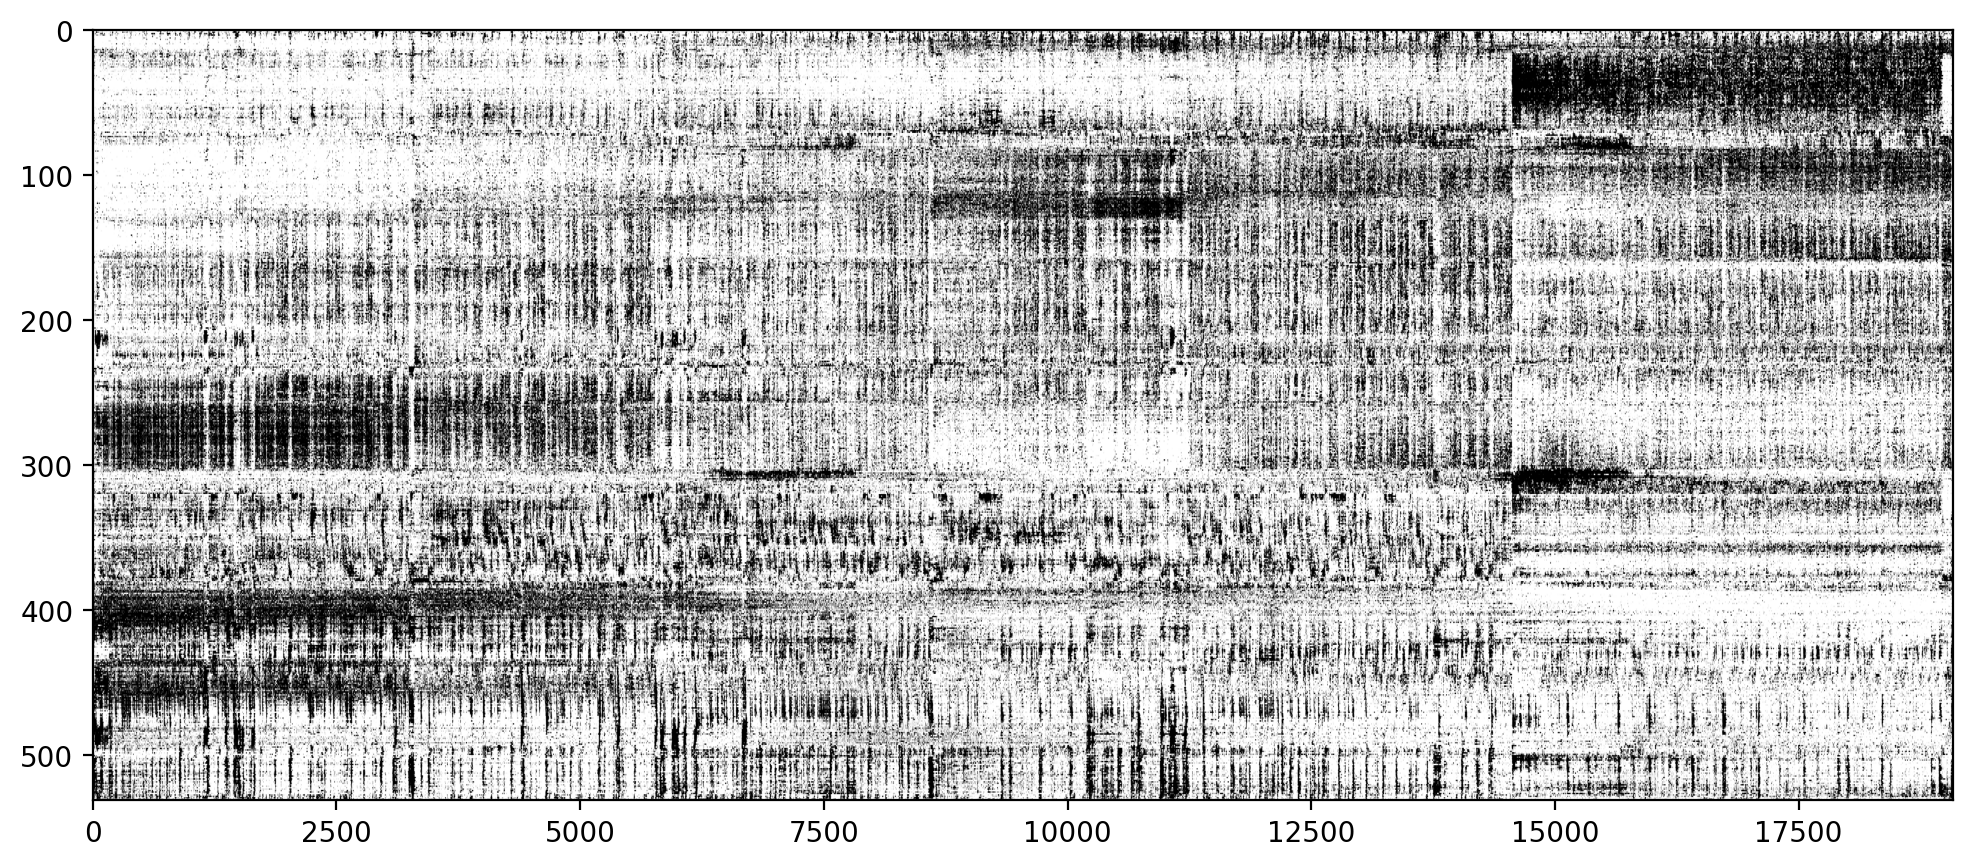

In [17]:
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5), dpi=200)
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=0.8, cmap="gray_r", aspect="auto")